In [2]:
import pyfits
from scipy.ndimage import gaussian_filter
import scipy.optimize as opt
import numpy as np
import pylab as plt
import rydlab
import pandas as pd
from fitting2d import Fit2d2Gaussian
import os
import copy
from lmfit import Model
from lmfit.models import LorentzianModel
from lmfit.models import ExponentialModel
from lmfit.models import ConstantModel

pd.options.display.max_colwidth = 120

import seaborn as sns
sns.set_style("darkgrid")
import matplotlib as mpl
mpl.rc('image', cmap='afmhot')

file_date = '2019-06-05'
path = 'A:/Projekte - Projects/2019_IEI/July/02'
folders = rydlab.analyze_folder(path,filter=0)
slicer = (slice(10,110),slice(10,410))
binning_scale = 1
folders

Name  \
0                                  A:/Projekte - Projects/2019_IEI/July/02\EITshift   
1                  A:/Projekte - Projects/2019_IEI/July/02\EITshift_averaged_images   
2                           A:/Projekte - Projects/2019_IEI/July/02\dummyscanblue01   
3           A:/Projekte - Projects/2019_IEI/July/02\dummyscanblue01_averaged_images   
4                                   A:/Projekte - Projects/2019_IEI/July/02\eitspec   
5                               A:/Projekte - Projects/2019_IEI/July/02\scanblueres   
6               A:/Projekte - Projects/2019_IEI/July/02\scanblueres_averaged_images   
7                   A:/Projekte - Projects/2019_IEI/July/02\scanblueresonance_FINAL   
8   A:/Projekte - Projects/2019_IEI/July/02\scanblueresonance_FINAL_averaged_images   
9                             A:/Projekte - Projects/2019_IEI/July/02\tof_final0001   
10            A:/Projekte - Projects/2019_IEI/July/02\tof_final0001_averaged_images   
11                                  A:/Projekte - Projects/2019_IEI/July/02\tofscan   
12                  A:/Projekte - Projects/2019_IEI/July/02\tofscan_averaged_images   

    Valid  
0    True  
1   False  
2    True  
3   False  
4    True  
5    True  
6   False  
7    True  
8   False  
9    True  
10  False  
11   True  
12  False

In [91]:
path=folders.Name[10]

os.chdir(path)

variables = np.loadtxt( '2019-06-05_variables.dat' )[:,1]
N = len(variables)
print(os.getcwd())

def fitsopen(n,bg):
    if n<10:
        hdulist = pyfits.open(file_date+str("_")+str(0)+str(n)+'.fts')
    else:
        hdulist = pyfits.open(file_date+str("_")+str(n)+'.fts')

    data=np.zeros((90,400))

    for y in range(10,100):
        for x in range(10,410):
            data[y-10,x-10]=-np.log((hdulist[0].data[0,y,x]-hdulist[0].data[2,y,x])/(hdulist[0].data[1,y,x]-hdulist[0].data[2,y,x]))

    hdulist.close()
    return gaussian_filter(data-bg, 1, order=0, output=None, mode='constant', cval=0.0, truncate=4.0)

def fitsopen_bg(n,bg):
    hdulist = pyfits.open(file_date+str("_")+str(n).zfill(2)+'.fts')
    images = hdulist[0].data
    no_absorb = images[0]
    absorb = images[1]
    div = (no_absorb-bg)/(absorb-bg)
    
    div = div[slicer]
    div = -np.log(div)
    div = np.nan_to_num(div)
    return div

def twoD_Gaussian(xy_mesh, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xy_mesh
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)
                        + c*((y-yo)**2)))
    return g.flatten()


def two_Gaussian(xy_mesh, amplitude1, xo1, yo1, sigma_x1, sigma_y1, theta1, amplitude2, xo2, yo2, sigma_x2, sigma_y2, theta2, offset):
    (x, y) = xy_mesh
    xo1 = float(xo1)
    yo1 = float(yo1)
    xo2 = float(xo2)
    yo2 = float(yo2)

    a1 = (np.cos(theta1)**2)/(2*sigma_x1**2) + (np.sin(theta1)**2)/(2*sigma_y1**2)
    b1 = -(np.sin(2*theta1))/(4*sigma_x1**2) + (np.sin(2*theta1))/(4*sigma_y1**2)
    c1 = (np.sin(theta1)**2)/(2*sigma_x1**2) + (np.cos(theta1)**2)/(2*sigma_y1**2)
    a2 = (np.cos(theta2)**2)/(2*sigma_x2**2) + (np.sin(theta2)**2)/(2*sigma_y2**2)
    b2 = -(np.sin(2*theta2))/(4*sigma_x2**2) + (np.sin(2*theta2))/(4*sigma_y2**2)
    c2 = (np.sin(theta2)**2)/(2*sigma_x2**2) + (np.cos(theta2)**2)/(2*sigma_y2**2)

    g = offset + amplitude1*np.exp( - (a1*((x-xo1)**2) + 2*b1*(x-xo1)*(y-yo1) + c1*((y-yo1)**2))) + amplitude2*np.exp( - (a2*((x-xo2)**2) + 2*b2*(x-xo2)*(y-yo2) + c2*((y-yo2)**2)))

    return g.flatten()


def make_background(N):
    list_bg=list()
    for n in range(0,N):
        hdulist = pyfits.open(file_date+str("_")+str(n).zfill(2)+'.fts')
        list_bg.append(hdulist[0].data[2])
        hdulist.close()
    bg_mean = np.array(list_bg).mean(axis=0)
    bg_std = np.array(list_bg).std(axis=0)
    return bg_mean,bg_std
        

def lorentz(x_array,gamma,xoo,a,o):
    xoo = float(xoo)
    gamma = float(gamma)
    x=x_array
    #print(x)
    #print(type(x))
    #l=gamma/((2*np.pi)((x-xoo)**2 + (gamma/2)**2))
    l=a*gamma/( (x-xoo)**2 + (gamma/2)**2 )+o
    #print(l)
    #print(type(l))
    return l#/(2*np.pi)



model_twoG = Model(two_Gaussian)
from lmfit import Parameters
params = Parameters()

params = model_twoG.make_params()

# cloud distribution
params.add('amplitude1',value=0.0)
params.add('yo1',value=160*binning_scale,min=140*binning_scale,max=180*binning_scale)
params.add('xo1',value=45*binning_scale,min=30*binning_scale,max=60*binning_scale)
params.add('sigma_x1',value=5*binning_scale,min=30*binning_scale,max=200*binning_scale)
params.add('sigma_y1',value=5*binning_scale,min=30*binning_scale,max=200*binning_scale)
params.add('theta1',value=0,min=0,max=np.pi)

# EIT/Autler-Townes-dip
params.add('amplitude2',value=0.00, vary=False)
params.add('yo2',value=171.2*binning_scale,min=168*binning_scale,max=175*binning_scale)
params.add('xo2',value=48.1*binning_scale,min=46*binning_scale,max=50*binning_scale)
params.add('sigma_x2',value=10*binning_scale,min=3*binning_scale,max=15*binning_scale)
#params.add('sigma_y2',value=10,min=3,max=15)
params.add('sigma_y2',expr='sigma_x2')
params.add('theta2',value=0,min=0,max=np.pi,vary=False)

# offset
params.add('offset',value=0)
bg_mean,bg_std = make_background(N)
#image = fitsopen_bg(n,bg_mean)
#image
#plt.imshow(image)
print(np.shape(bg_mean))

A:\Projekte - Projects\2019_IEI\July\02\tof_final0001_averaged_images


C:\Users\Control_Computer\AppData\Local\conda\conda\envs\rydlab\lib\site-packages\pyfits\util.py:899: UserWarning:

Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.



(100, 512)


In [92]:
model_1G = Model(twoD_Gaussian)

params = model_1G.make_params()

# cloud distribution
params.add('amplitude',value=0.0)
params.add('yo',value=158*binning_scale,min=140*binning_scale,max=180*binning_scale,vary=False)
params.add('xo',value=45*binning_scale,min=30*binning_scale,max=60*binning_scale)
params.add('sigma_x',value=5*binning_scale,min=10*binning_scale,max=400*binning_scale)
params.add('sigma_y',value=5*binning_scale,min=10*binning_scale,max=400*binning_scale)
params.add('theta',value=0,min=0,max=np.pi)
params.add('offset',value=0.0,vary=False)

In [93]:
model=model_1G

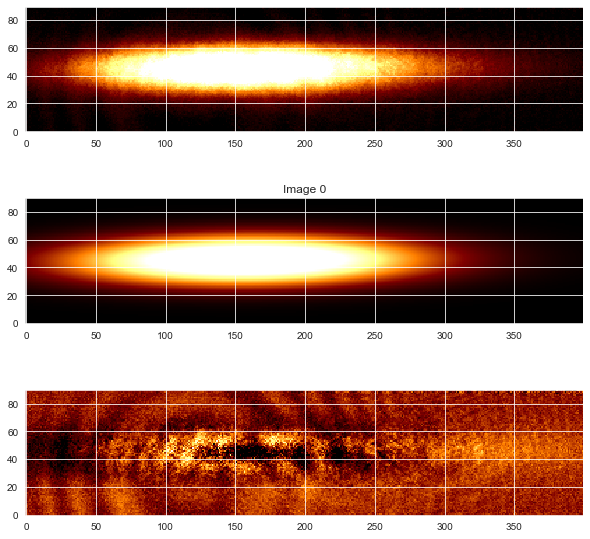

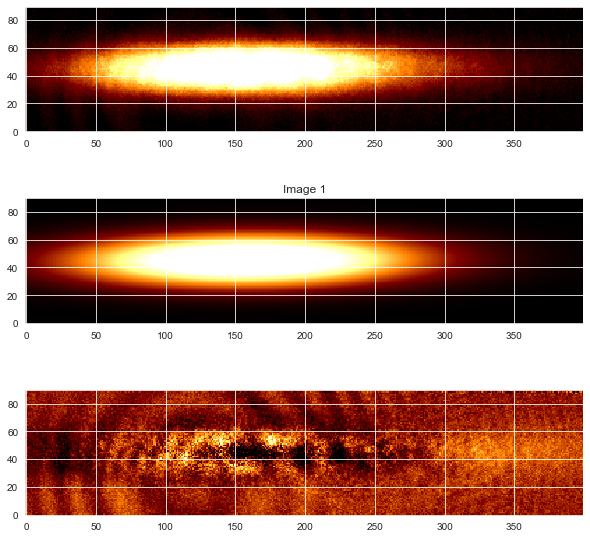

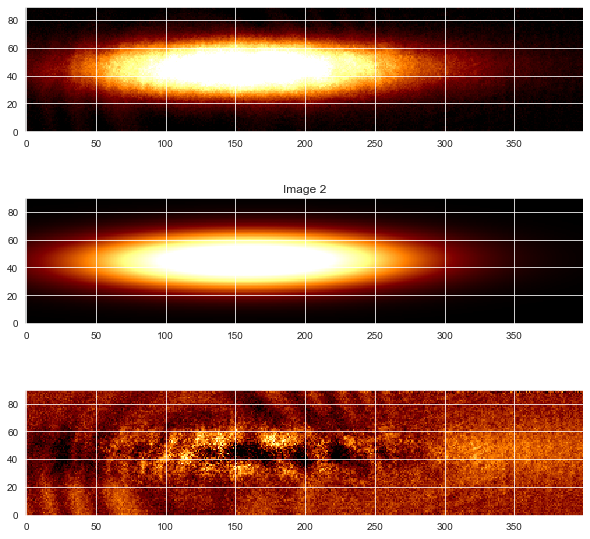

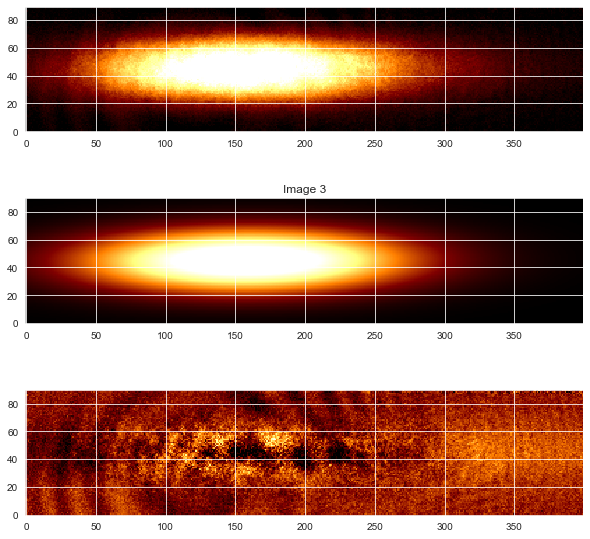

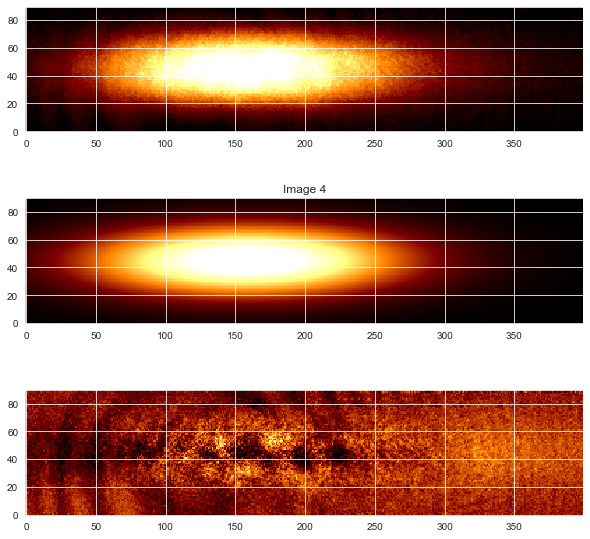

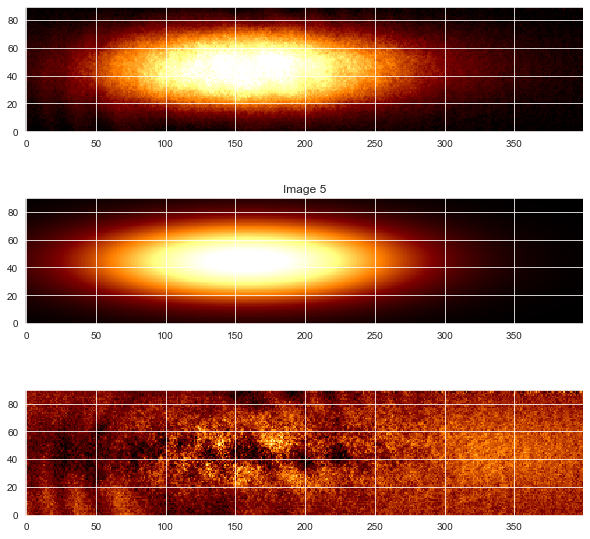

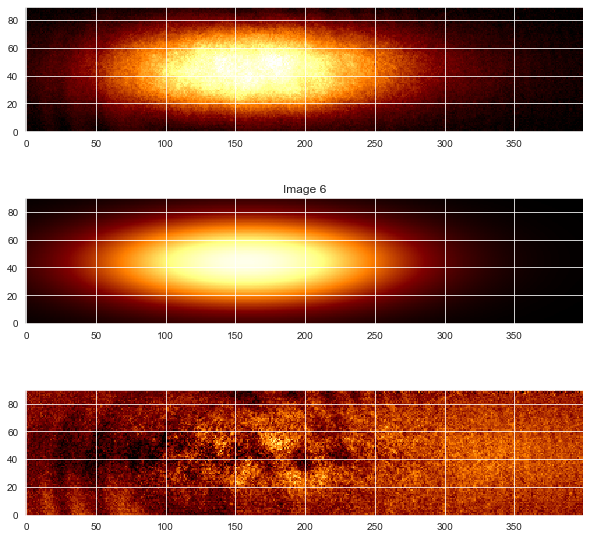

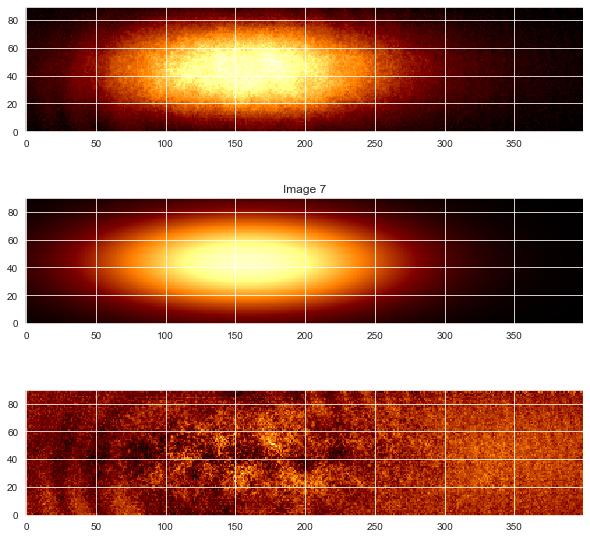

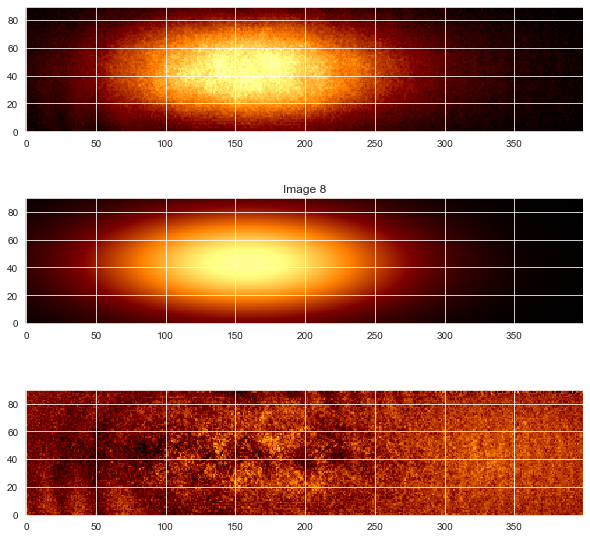

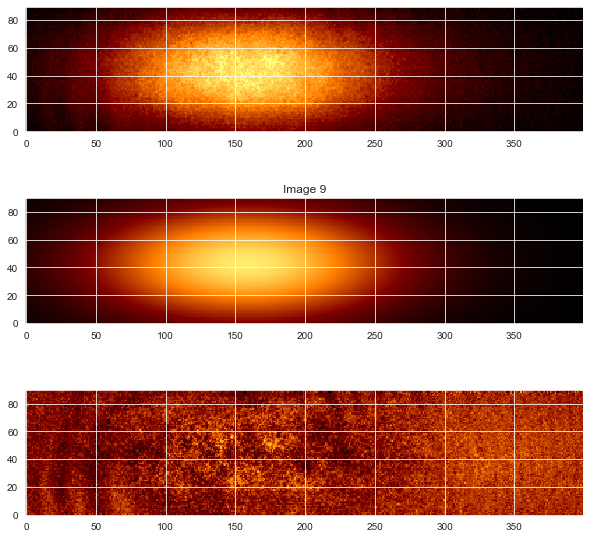

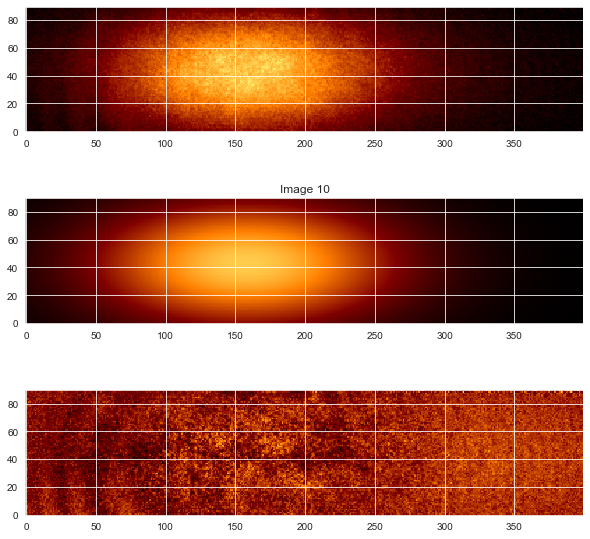

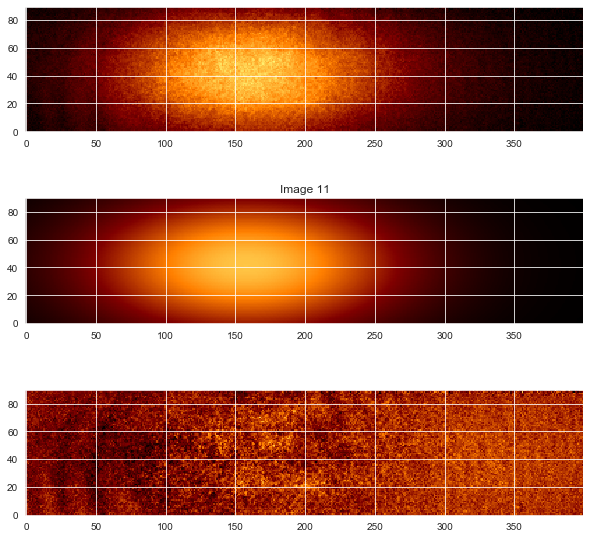

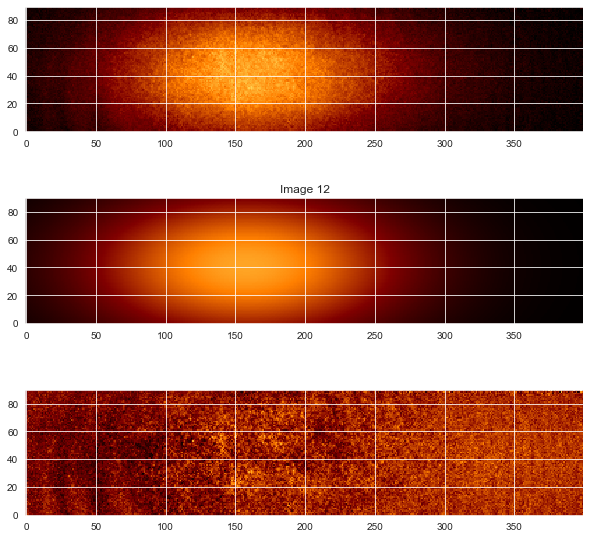

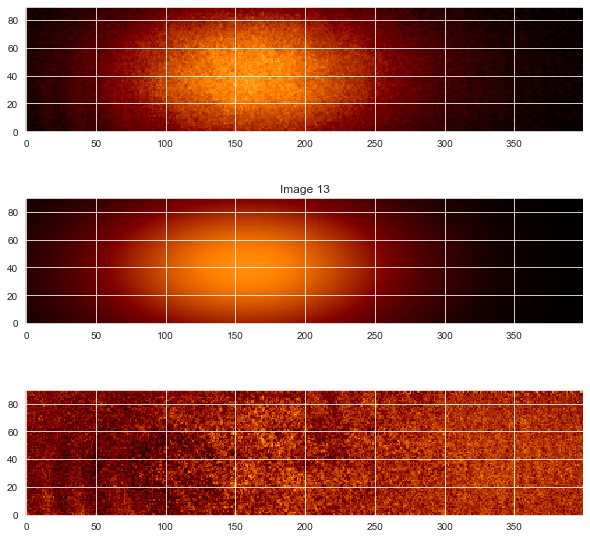

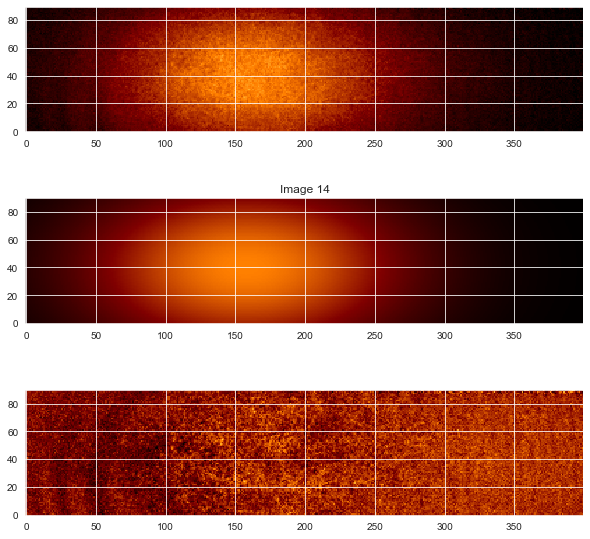

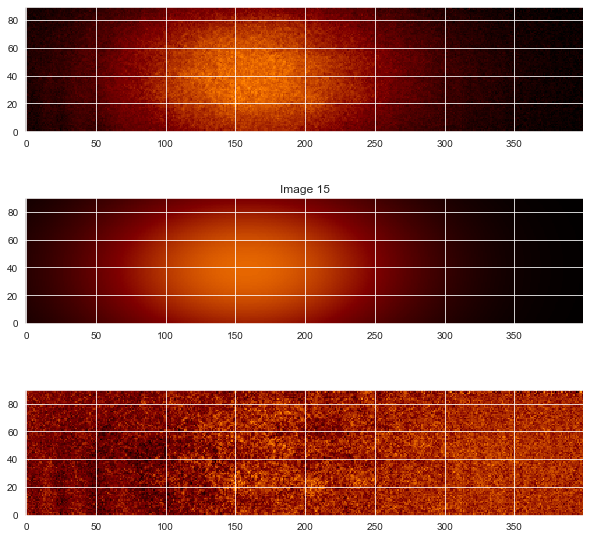

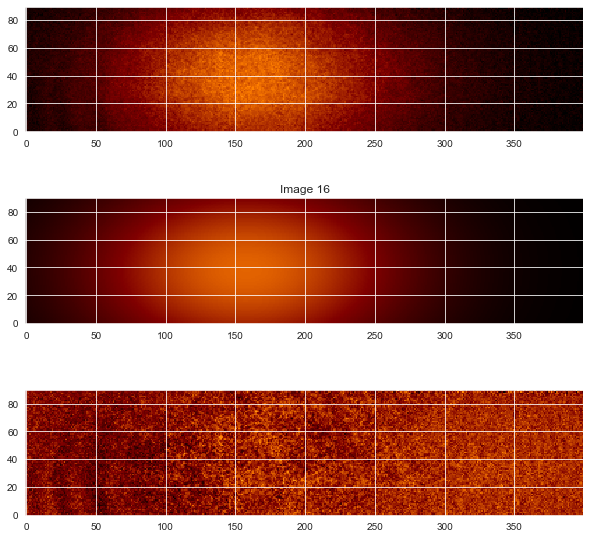

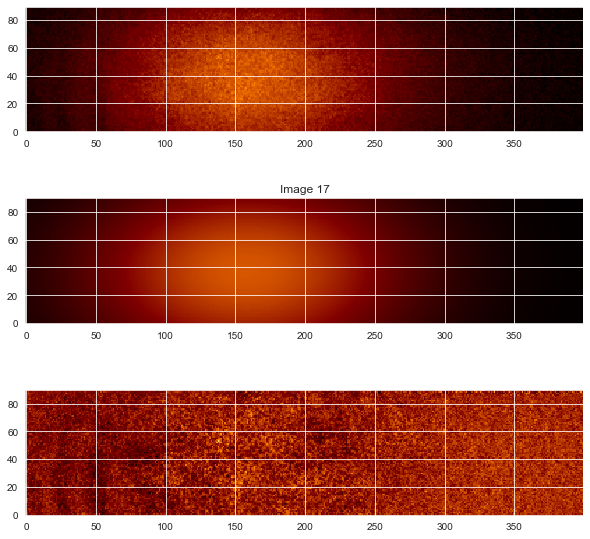

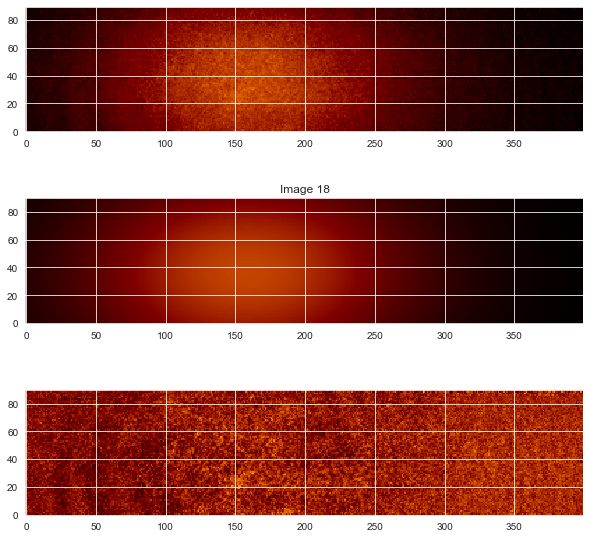

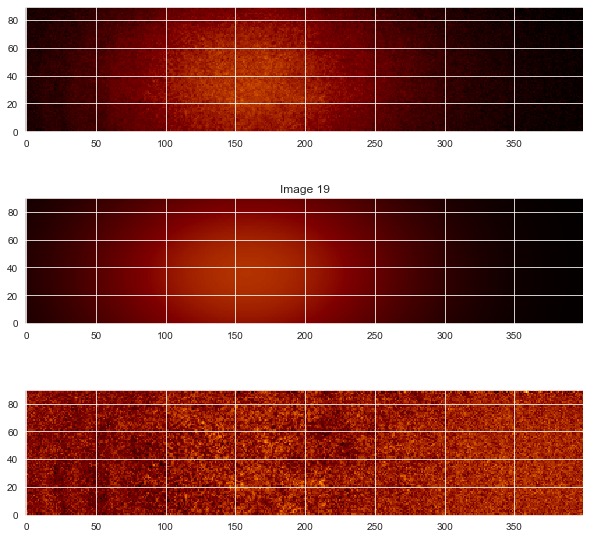

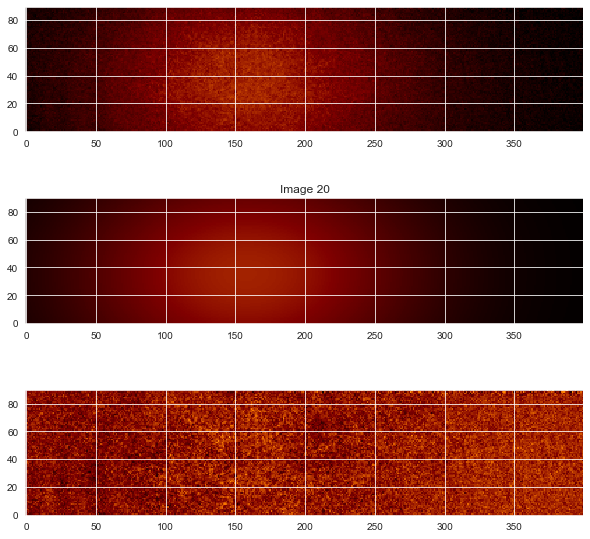

In [94]:
results=list()
for n in range(0,len(variables)):
    bg,std= make_background(N)
    image = fitsopen_bg(n,bg)
    #image =  gaussian_filter(image, 1, order=0, output=None, mode='constant', cval=0.0, truncate=4.0)
    shape = image.shape
    x,y = np.mgrid[0:shape[0],0:shape[1]]
    image_flat=image.flatten()    
    out = model.fit(image_flat,params,xy_mesh=(x,y))##method='Powel')
    fig,ax = plt.subplots(3,1,figsize=(10,10))
    results.append(copy.deepcopy(out))
    params = out.params
    vmax = 2
    ax[0].imshow(image,
                 origin='bottom',vmin=0, vmax=vmax)
    ax[1].set_title('Image '+str(n))
    ax[1].imshow(out.best_fit.reshape(shape),
                 origin='bottom',vmin=0, vmax=vmax)
    ax[2].imshow((image-out.best_fit.reshape(shape)),
                 origin='bottom',vmin=-0.2, vmax=vmax/4)
    plt.show()

In [95]:
def TOF(t,T,B):
    m = 1.44316076857e-25
    kB = 1.38064852e-23
    return np.sqrt(kB*T/m*t**2+B**2)
model =Model(TOF)#+ConstantModel()
params = model.make_params()
params.add('T',value=1.0e-6)
params.add('B',value=0)
#params.add('amplitude',value=1.0)
#params.add('x0',value=1.0)

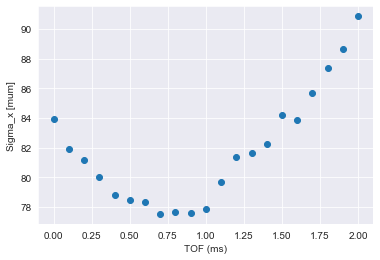

In [97]:
y = np.array([r.params['sigma_y'].value for r in results])
yerr = [r.params['sigma_x'].stderr for r in results]
x = variables



eff_pixel_size = 1# 2.0779e-6

y = y * eff_pixel_size
#x = x*1.0e-3
#plt.plot(x*1.0e3,y*1.0e6,'o')
plt.plot(x,y,'o')
#plt.errorbar(x,y,yerr=yerr,marker='o',linestyle='')

#out = model_AT.fit(y,params=params,Dc=variables )

v = np.linspace(min(x),max(x),200)
#plt.plot(v,model.eval(params=params,x=v))
#fit = model.fit(y,t=x,params=params,nan_policy='omit')
#fit.plot_fit()
#popt1, pcov1 = opt.curve_fit(lorentz,variables,y, p0=(2.5,1.,-0.13,0.1))

#plt.plot(variables,lorentz(np.array(variables), *popt1))


#plt.plot(v*1000,model.eval(params=fit.params,t=v)*1e6)

plt.xlabel("TOF (ms)")
plt.ylabel("Sigma_x [mum]")
plt.savefig("tof-temperature.png")
plt.show()
#n = np.argmax(-np.array(valdiv))

In [41]:
%notebook -e analysis.ipynb

In [88]:
results[10].params.pretty_print()

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude     1.304     -inf      inf 0.0009582     True     None     None
offset            0     -inf      inf        0    False     None     None
sigma_x       31.75       10      400  0.03433     True     None     None
sigma_y       77.88       10      400  0.05638     True     None     None
theta      4.09e-11        0    3.142 2.835e-05     True     None     None
xo            42.39       30       60  0.02507     True     None     None
yo              158      140      180        0    False     None     None


In [90]:
results[-1].params.pretty_print()

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude    0.6351     -inf      inf 0.0006107     True     None     None
offset            0     -inf      inf        0    False     None     None
sigma_x       57.66       10      400   0.2104     True     None     None
sigma_y       90.86       10      400  0.08729     True     None     None
theta      0.009305        0    3.142 0.002231     True     None     None
xo            35.08       30       60   0.1033     True     None     None
yo              158      140      180        0    False     None     None


In [42]:
fit